<a href="https://colab.research.google.com/github/haonguyenuet/person_reid/blob/master/person_reid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch import nn

import torchvision.transforms as T

import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from collections import namedtuple

import os
import os.path as osp
import tarfile
import zipfile
import re
import glob
import urllib
import sys
import warnings
import errno
import unittest

# Utils

In [2]:
def mkdir_if_missing(dirname):
    """Creates dirname if it is missing."""
    if not osp.exists(dirname):
        try:
            os.makedirs(dirname)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise


def isfile(fpath):
    isfile = osp.isfile(fpath)
    if not isfile:
        warnings.warn('No file found at "{}"'.format(fpath))
    return isfile

def read_image(path):
    got_img = False
    if not osp.exists(path):
        raise IOError('"{}" does not exist'.format(path))
    while not got_img:
        try:
            img = Image.open(path).convert('RGB')
            got_img = True
        except IOError:
            print(
                'IOError incurred when reading "{}". Will redo. Don\'t worry. Just chill.'
                .format(path)
            )
    return img

def download_url(url, dst):
    """Downloads file from a url to a destination.
    Args:
        url (str): url to download file.
        dst (str): destination path.
    """
    print('* url="{}"'.format(url))
    print('* destination="{}"'.format(dst))

    def _reporthook(count, block_size, total_size):
        progress_size = int(count * block_size)
        percent = int(progress_size * 100 / total_size)
        sys.stdout.write(
            '\r...%d%%, %d MB' %
            (percent, progress_size / (1024*1024))
        )
        sys.stdout.flush()

    urllib.request.urlretrieve(url, dst, _reporthook)
    sys.stdout.write('\n')

#Prepare Data ✔

### ImageDataset


In [3]:
class ImageDataset(object):
    """
    Args:
        train (list): contains tuples of (img_path(s), pid, camid).
        query (list): contains tuples of (img_path(s), pid, camid).
        gallery (list): contains tuples of (img_path(s), pid, camid).
        transform: transform function.
        mode (str): 'train', 'query' or 'gallery'.
    """

    def __init__(
        self,
        train,
        query,
        gallery,
        mode='train',
        transform=None,
    ):
        # adding a dataset indicator "dsetid"
        # (img_path(s), pid, camid) ==> (img_path(s), pid, camid, dsetid)

        if len(train[0]) == 3:
            train = [(*items, 0) for items in train]
        if len(query[0]) == 3:
            query = [(*items, 0) for items in query]
        if len(gallery[0]) == 3:
            gallery = [(*items, 0) for items in gallery]

        self.train = train
        self.query = query
        self.gallery = gallery
        self.transform = transform
        self.mode = mode

        self.num_train_pids = self.get_num_pids(self.train)
        self.num_train_cams = self.get_num_cams(self.train)

        if self.mode == 'train':
            self.data = self.train
        elif self.mode == 'query':
            self.data = self.query
        elif self.mode == 'gallery':
            self.data = self.gallery
        else:
            raise ValueError(
                'Invalid mode. Got {}, but expected to be '
                'one of [train | query | gallery]'.format(self.mode)
            )
    
    def __getitem__(self, index):
        img_path, pid, camid, dsetid = self.data[index]
        img = read_image(img_path)
        if self.transform is not None:
            img = self.transform(img)
        item = {
            'img': img,
            'pid': pid,
            'camid': camid,
            'impath': img_path,
            'dsetid': dsetid
        }
        return item

    def __len__(self):
        return len(self.data)
    
    def get_num_pids(self, data):
        pids = set()
        for items in data:
            pid = items[1]
            pids.add(pid)
        return len(pids)

    def get_num_cams(self, data):
        cams = set()
        for items in data:
            camid = items[2]
            cams.add(camid)
        return len(cams)

    def download_dataset(self, dataset_dir, dataset_url):
        if osp.exists(dataset_dir):
            return

        print('Creating directory "{}"'.format(dataset_dir))
        mkdir_if_missing(dataset_dir)
        fpath = osp.join(dataset_dir, osp.basename(dataset_url))

        download_url(dataset_url, fpath)
        print('Extracting "{}"'.format(fpath))
        try:
            tar = tarfile.open(fpath)
            tar.extractall(path=dataset_dir)
            tar.close()
        except:
            zip_ref = zipfile.ZipFile(fpath, 'r')
            zip_ref.extractall(dataset_dir)
            zip_ref.close()

        print('{} dataset is ready'.format(self.__class__.__name__))

    def check_required_files(self, required_files):
        for fpath in required_files:
            if not osp.exists(fpath):
                raise RuntimeError('"{}" is not found'.format(fpath))

### Market1501


In [4]:
class Market1501(ImageDataset):
    dataset_dir = 'market1501'
    dataset_url = 'http://188.138.127.15:81/Datasets/Market-1501-v15.09.15.zip'

    def __init__(self, root='', **kwargs):
        self.root = osp.abspath(osp.expanduser(root))
        self.dataset_dir = osp.join(self.root, self.dataset_dir)
        self.download_dataset(self.dataset_dir, self.dataset_url)

        data_dir = osp.join(self.dataset_dir, 'Market-1501-v15.09.15')
        if osp.isdir(data_dir):
            self.data_dir = data_dir

        self.train_dir = osp.join(self.data_dir, 'bounding_box_train')
        self.query_dir = osp.join(self.data_dir, 'query')
        self.gallery_dir = osp.join(self.data_dir, 'bounding_box_test')

        required_files = [
            self.data_dir, self.train_dir, self.query_dir, self.gallery_dir
        ]
        self.check_required_files(required_files)

        train = self.process_dir(self.train_dir, relabel=True)
        query = self.process_dir(self.query_dir, relabel=False)
        gallery = self.process_dir(self.gallery_dir, relabel=False)
      
        super().__init__(train, query, gallery, **kwargs)

    def process_dir(self, dir_path, relabel=False):
        img_paths = glob.glob(osp.join(dir_path, '*.jpg'))
        pattern = re.compile(r'([-\d]+)_c(\d)')

        pid_container = set()
        for img_path in img_paths:
            pid, _ = map(int, pattern.search(img_path).groups())
            if pid == -1:
                continue # junk images are just ignored
            pid_container.add(pid)
        pid2label = {pid: label for label, pid in enumerate(pid_container)}

        data = []
        for img_path in img_paths:
            pid, camid = map(int, pattern.search(img_path).groups())
            if pid == -1:
                continue # junk images are just ignored
            assert 0 <= pid <= 1501 # pid == 0 means background
            assert 1 <= camid <= 6
            camid -= 1 # index starts from 0
            if relabel:
                pid = pid2label[pid]
            data.append((img_path, pid, camid))

        return data

### DataPreparer

In [5]:
QueryGallery = namedtuple('QueryGallery', ['query', 'gallery'])
TrainTest = namedtuple('TrainTest', ['train', 'test'])

class DataPreparer(object):
    def __init__(
        self,
        root="",
        batch_size_train=32,
        batch_size_test=32,
        workers=4,
    ):
        self.root = root
        self.batch_size_train = batch_size_train
        self.batch_size_test = batch_size_test
        self.workers = workers

        self._build_transforms()
        self._prepare_data()

        self._num_train_pids = self.trainset.num_train_pids
        self._num_train_cams = self.trainset.num_train_cams

    @property
    def num_train_pids(self):
        return self._num_train_pids

    @property
    def num_train_cams(self):
        return self._num_train_cams
        
    def _build_transforms(self):
        norm_mean = [0.485, 0.456, 0.406]
        norm_std = [0.229, 0.224, 0.225]

        self.transform_train = T.Compose([
            T.Resize((256, 128)),
            T.Pad(10),
            T.RandomCrop((256,128)),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(mean=norm_mean, std=norm_std),
        ])

        self.transform_test = T.Compose([
            T.Resize((256, 128)),
            T.ToTensor(),
            T.Normalize(mean=norm_mean, std=norm_std),
        ])

    def _prepare_data(self):
        print('=> Loading train (source) dataset')
        self.trainset = Market1501(
            root=self.root,
            mode='train',
            transform=self.transform_train
        )

        self.queryset = Market1501(
            root=self.root,
            mode='query',
            transform=self.transform_test
        )

        self.galleryset = Market1501(
            root=self.root,
            mode='gallery',
            transform=self.transform_test
        )

    def train_loader(self):
        return DataLoader(
            dataset=self.trainset,
            batch_size= self.batch_size_train,
            shuffle=True,
            num_workers= self.workers,
            drop_last=True
        )

    def test_loader(self):
        return QueryGallery(
            query=DataLoader(
                dataset=self.queryset,
                batch_size= self.batch_size_test,
                shuffle=False,
                num_workers= self.workers
            ),
            gallery=DataLoader(
                dataset=self.galleryset,
                batch_size=self.batch_size_test,
                shuffle=False,
                num_workers=self.workers
            )
        )

=> Loading train (source) dataset
Creating directory "/content/data/market1501"
* url="http://188.138.127.15:81/Datasets/Market-1501-v15.09.15.zip"
* destination="/content/data/market1501/Market-1501-v15.09.15.zip"
...100%, 145 MB
Extracting "/content/data/market1501/Market-1501-v15.09.15.zip"
Market1501 dataset is ready
number of train pids: 751
number of train cids: 6


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(284)
torch.Size([3, 256, 128])


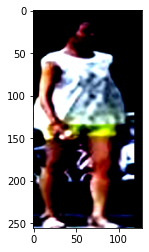

In [6]:
preparer = DataPreparer(root = "./data")
print("number of train pids:", preparer.num_train_pids)
print("number of train cids:", preparer.num_train_cams)

trainloader = preparer.train_loader()
data = iter(trainloader).next()
imgs, pids = data['img'], data['pid']
print(pids[31])
print(imgs[31].shape)
plt.imshow(imgs[31].permute(1, 2, 0))

# OSNet ✔


### Conv1x1 

In [7]:
class Conv1x1(nn.Module):
    """ 1x1 Conv -> Batch norm -> ReLU """

    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, 1, stride=stride, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(c_out)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Conv1x1Linear(nn.Module):
    """ 1x1 Conv -> Batch norm """
 
    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, 1, stride=stride, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(c_out)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

### LightConv3x3

In [8]:
class LightConv3x3(nn.Module):
    """ 1x1 Conv -> DW 3x3 Conv -> Batch norm -> ReLU """

    def __init__(self, c_in, c_out):
        super().__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, 1, stride=1, padding=0, bias=False)
        self.depthwise = nn.Conv2d(
            c_out, c_out, 3, stride=1, padding=1, bias=False, groups=c_out
				)
        self.bn = nn.BatchNorm2d(c_out)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.depthwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

### ConvLayer

In [9]:
class ConvLayer(nn.Module):
    """Conv -> Batch norm -> ReLU"""

    def __init__(self, c_in, c_out, kernel_size, stride=1, padding=0, groups=1):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, stride=stride,
                              padding=padding, bias=False, groups=groups)

        self.bn = nn.BatchNorm2d(c_out)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

### AggregationGate

In [10]:
class AggregationGate(nn.Module):

    def __init__(self, c_in):
        super().__init__()
        reduction = 16
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(c_in, c_in//reduction, kernel_size=1, bias=True, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(c_in//reduction, c_in, kernel_size=1, bias=True, padding=0)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        output = self.global_avgpool(x)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        output = self.activation(output)
        return output * x

### OSResBlock

In [11]:
class OSResBlock(nn.Module):
    def __init__(self, c_in, c_out, bottleneck_reduction=4, **kwargs):
        super().__init__()
        c_mid = c_out // bottleneck_reduction
        self.conv1 = Conv1x1(c_in, c_mid)
        self.conv2a = LightConv3x3(c_mid, c_mid)
        self.conv2b = nn.Sequential(
            LightConv3x3(c_mid, c_mid),
            LightConv3x3(c_mid, c_mid),
        )
        self.conv2c = nn.Sequential(
            LightConv3x3(c_mid, c_mid),
            LightConv3x3(c_mid, c_mid),
            LightConv3x3(c_mid, c_mid),
        )
        self.conv2d = nn.Sequential(
            LightConv3x3(c_mid, c_mid),
            LightConv3x3(c_mid, c_mid),
            LightConv3x3(c_mid, c_mid),
            LightConv3x3(c_mid, c_mid),
        )
        self.gate = AggregationGate(c_mid)
        self.conv3 = Conv1x1Linear(c_mid, c_out)
        self.downsample = None
        if c_in != c_out:
            self.downsample = Conv1x1Linear(c_in, c_out)
			
    def forward(self, x):
        residual = self.conv1(x)
        x_a = self.conv2a(residual)
        x_b = self.conv2b(residual)
        x_c = self.conv2c(residual)
        x_d = self.conv2d(residual)
        residual = self.gate(x_a) + self.gate(x_b) + self.gate(x_c) + self.gate(x_d)
        residual = self.conv3(residual)
        if self.downsample is not None:
            x = self.downsample(x)
        out = x + residual
        return F.relu(out)

### OSNet

In [12]:
class OSNet(nn.Module):
    def __init__(self,
								num_classes = 751, 
								blocks=[OSResBlock, OSResBlock, OSResBlock], 
								layers=[2, 2, 2],
                channels=[64, 256, 384, 512],
								fc_dim=512,
								loss='softmax'):
        super().__init__()
        self.loss = loss

        # convolutional backbone
        self.conv1 = ConvLayer(3, channels[0], 7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2 = self._make_layer(blocks[0], layers[0], channels[0], channels[1])
        self.tran1 =  nn.Sequential(
                    Conv1x1(channels[1], channels[1]),
                    nn.AvgPool2d(2, stride=2)
        )
        self.conv3 = self._make_layer(blocks[1], layers[1], channels[1], channels[2])
        self.tran2 =  nn.Sequential(
                    Conv1x1(channels[2], channels[2]),
                    nn.AvgPool2d(2, stride=2)
        )
        self.conv4 = self._make_layer(blocks[2], layers[2], channels[2], channels[3])
        self.conv5 = Conv1x1(channels[3], channels[3])
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        # fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(channels[3], fc_dim),
            nn.BatchNorm1d(fc_dim),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Linear(fc_dim, num_classes)

    def _make_layer(self, block, num_layers, c_in, c_out):
        layers = []

        layers.append(block(c_in, c_out))
        for i in range(1, num_layers):
            layers.append(block(c_out, c_out))

        return nn.Sequential(*layers)

    def featuremaps(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.tran1(x)
        x = self.conv3(x)
        x = self.tran2(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

    def forward(self, x):
        x = self.featuremaps(x)
        v = self.global_avgpool(x)
        v = v.view(v.size(0), -1)
        v = self.fc(v)
        y = self.classifier(v)
        return y

# CrossEntropyLoss ✔

In [13]:
class CrossEntropyLoss(nn.Module):
    def __init__(self, num_classes, use_gpu=True, label_smooth = True):
        super(CrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.eps = 0.1 if label_smooth else 0
        self.use_gpu = use_gpu
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, logits, targets):
        """
        Args:
            logits: prediction matrix with shape (batch_size, num_classes).
            targets: Each position contains the true label index
										 with shape (batch_size).
        """
        log_probs = self.logsoftmax(logits)
        zeros = torch.zeros(log_probs.size())
        y = zeros.scatter_(1, targets.unsqueeze(1).data.cpu(), 1)
        if self.use_gpu:
            y = y.cuda()
        y = (1 - self.eps) * y + self.eps / self.num_classes
        return (-y * log_probs).mean(0).sum()

#Distance

In [14]:
def cosine_distance(input1, input2):
    input1_normed = F.normalize(input1, p=2, dim=1)
    input2_normed = F.normalize(input2, p=2, dim=1)
    distmat = 1 - torch.mm(input1_normed, input2_normed.t())
    return  distmat

# Unit Tests ✔

### TestConv1x1

In [ ]:
class TestConv1x1(unittest.TestCase):
  def test_ouput(self):
    layer1 = Conv1x1(c_in=3, c_out = 1)
    layer2 = Conv1x1Linear(c_in=3, c_out = 1)
    input = torch.randn(1, 3, 256, 128)
    output1 = layer1(input)
    output2 = layer2(input)

    self.assertEqual(output1.shape, (1, 1, 256, 128))
    self.assertEqual(output2.shape, (1, 1, 256, 128))


### TestLightConv3x3

In [ ]:
class TestLightConv3x3(unittest.TestCase):
  def test_ouput(self):
    layer = LightConv3x3(c_in=10, c_out = 5)
    input = torch.randn(1, 10, 256, 128)
    output = layer(input)

    self.assertEqual(output.shape, (1, 5, 256, 128))

### TestConvLayer

In [ ]:
class TestConvLayer(unittest.TestCase):
  def test_ouput(self):
    layer1 = ConvLayer(c_in=10, c_out = 5, kernel_size=5, padding = 0)
    layer2 = ConvLayer(c_in=10, c_out = 8, kernel_size=5, padding = 1)
    layer3 = ConvLayer(c_in=10, c_out = 10, kernel_size=5, padding = 2)

    input = torch.randn(1, 10, 256, 128)
    output1 = layer1(input)
    output2 = layer2(input)
    output3 = layer3(input)

    self.assertEqual(output1.shape, (1, 5, 252, 124))
    self.assertEqual(output2.shape, (1, 8, 254, 126))
    self.assertEqual(output3.shape, (1, 10, 256, 128))

### TestOSResBlock

In [ ]:
class TestOSResBlock(unittest.TestCase):
  def test_ouput(self):
    layer1 = OSResBlock(c_in=64, c_out = 128, bottleneck_reduction = 4)
    layer2 = OSResBlock(c_in=128, c_out = 256, bottleneck_reduction = 2)

    input = torch.randn(1, 64, 64, 32)
    output1 = layer1(input)
    output2 = layer2(output1)

    self.assertEqual(output1.shape, (1, 128, 64, 32))
    self.assertEqual(output2.shape, (1, 256, 64, 32))

### TestOSNet

In [ ]:
class TestOSNet(unittest.TestCase):
  def test_ouput(self):
    model = OSNet(num_classes=10)

    batch_size = 2
    input = torch.randn(2, 3, 256, 128)
    stage1 = model.conv1(input)
    stage1 = model.maxpool(stage1)

    stage2 = model.conv2(stage1)
    stage2 = model.tran1(stage2)

    stage3 = model.conv3(stage2)
    stage3 = model.tran2(stage3)

    stage4 = model.conv4(stage3)
    stage5 = model.conv5(stage4)

    feature = model.featuremaps(input)
    output = model(input)

    self.assertEqual(model.loss, 'softmax')
    self.assertEqual(stage1.shape, (batch_size, 64, 64, 32))
    self.assertEqual(stage2.shape, (batch_size, 256, 32, 16))
    self.assertEqual(stage3.shape, (batch_size, 384, 16, 8))
    self.assertEqual(stage4.shape, (batch_size, 512, 16, 8))
    self.assertEqual(stage5.shape, (batch_size, 512, 16, 8))
    self.assertEqual(feature.shape, stage5.shape)
    self.assertEqual(output.shape, (batch_size, 10))

# Run test ✔

In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_ouput (__main__.TestConv1x1) ... ok
test_ouput (__main__.TestConvLayer) ... ok
test_ouput (__main__.TestLightConv3x3) ... ok
test_ouput (__main__.TestOSNet) ... ok
test_ouput (__main__.TestOSResBlock) ... ok

----------------------------------------------------------------------
Ran 5 tests in 1.096s

OK


# Training ✔

In [ ]:
def train_epoch(epoch, model, trainloader, criterion, optimizer, print_freq = 10, use_gpu = True):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for batch_index, data in enumerate(trainloader):
      loss, acc = forward_backward(model, data, criterion, optimizer, use_gpu)

      running_loss += loss
      running_acc += acc
      if (batch_index + 1) % print_freq == 0:
        print('[%d, %5d]\t loss: %.3f\t accuracy: %.3f' 
              %(epoch + 1, batch_index + 1, running_loss / print_freq, running_acc / print_freq))
        running_loss = 0.0
        running_acc  = 0.0

def forward_backward(model, data, criterion, optimizer, use_gpu = True):
    imgs, pids = parse_data_for_train(data)
    
    if use_gpu:
        imgs, pids = imgs.cuda(), pids.cuda()

    logits = model(imgs)
    loss = criterion(logits, pids)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    _, prediction = torch.max(logits, dim=1)
    acc = (prediction == pids).sum() * 100 / len(pids)
    
    return loss.item(), acc.item()

def parse_data_for_train(data):
    imgs = data['img']
    pids = data['pid']
    return imgs, pids

def main(max_epoch = 15, print_freq = 10, use_gpu = True):
    data_preparer = DataPreparer(root='./data')

    if torch.cuda.is_available() == False:
       use_gpu = False

    model = OSNet(num_classes = data_preparer.num_train_pids)
    if use_gpu:
       model = model.cuda()

    criterion = CrossEntropyLoss(num_classes = data_preparer.num_train_pids)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

    for epoch in range(max_epoch):
        train_epoch(    
            epoch = epoch,
            model=model,
            trainloader = data_preparer.train_loader(),
            criterion = criterion,
            optimizer = optimizer,
            print_freq=print_freq,
            use_gpu=use_gpu
        )
        torch.save(model.state_dict(), './pretrained_model.pth')

main(use_gpu = True)

=> Loading train (source) dataset


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    10]	 loss: 6.708	 accuracy: 0.000
[1,    20]	 loss: 6.654	 accuracy: 0.625
[1,    30]	 loss: 6.636	 accuracy: 1.250
[1,    40]	 loss: 6.547	 accuracy: 0.938
[1,    50]	 loss: 6.516	 accuracy: 0.938
[1,    60]	 loss: 6.529	 accuracy: 1.562
[1,    70]	 loss: 6.506	 accuracy: 1.250
[1,    80]	 loss: 6.400	 accuracy: 1.250
[1,    90]	 loss: 6.471	 accuracy: 0.625
[1,   100]	 loss: 6.425	 accuracy: 0.938
[1,   110]	 loss: 6.365	 accuracy: 0.312
[1,   120]	 loss: 6.322	 accuracy: 0.938
[1,   130]	 loss: 6.300	 accuracy: 1.562
[1,   140]	 loss: 6.321	 accuracy: 0.312
[1,   150]	 loss: 6.276	 accuracy: 1.250
[1,   160]	 loss: 6.238	 accuracy: 1.562
[1,   170]	 loss: 6.211	 accuracy: 1.562
[1,   180]	 loss: 6.135	 accuracy: 2.188
[1,   190]	 loss: 6.122	 accuracy: 3.438
[1,   200]	 loss: 6.199	 accuracy: 1.250
[1,   210]	 loss: 6.137	 accuracy: 1.250
[1,   220]	 loss: 6.081	 accuracy: 2.188
[1,   230]	 loss: 6.008	 accuracy: 1.562
[1,   240]	 loss: 5.987	 accuracy: 2.500
[1,   250]	 loss

# Testing ✔

=> Loading train (source) dataset


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Computing feature distance ...
Sorting feature distance ...
Computing CMC and mAP ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dataset statistics:
  ----------------------------------------
  distance  | rank1 | rank5 | mAP
  ----------------------------------------
  cosine    | 100.00  | 100.00  | 49.87 
  ----------------------------------------
Top 10 images are as follow:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


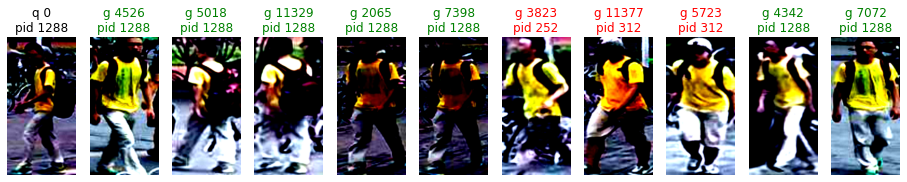

In [22]:
class Tester(object):
    def __init__(self, model, dm, use_gpu):
        self.model = model
        self.dm = dm
        self.use_gpu = use_gpu
        self.calc_distmat()

    def compute_rank_market1501(self, max_rank = 10):
        num_q, num_g = self.distmat.shape
        print('Computing CMC and mAP ...')
        all_cmc = []
        all_AP = []
        num_valid_q = 0. # number of valid query

        for q_idx in range(num_q):
            # compute cmc curve
            raw_cmc, _ = self.remove_duplication(q_idx)
            if not np.any(raw_cmc):
                # this condition is true when query identity does not appear in gallery
                continue

            cmc = raw_cmc.cumsum()
            cmc[cmc > 1] = 1

            all_cmc.append(cmc[:max_rank])
            num_valid_q += 1.

            # compute average precision
            num_rel = raw_cmc.sum()
            tmp_cmc = raw_cmc.cumsum()
            tmp_cmc = [x / (i+1.) for i, x in enumerate(tmp_cmc)]
            tmp_cmc = np.asarray(tmp_cmc) * raw_cmc
            AP = tmp_cmc.sum() / num_rel
            all_AP.append(AP)

        assert num_valid_q > 0, 'Error: all query identities do not appear in gallery'

        all_cmc = np.asarray(all_cmc).astype(np.float32)
        all_cmc = all_cmc.sum(0) / num_valid_q
        mAP = np.mean(all_AP)
        return cmc, mAP

    def visualize(self, q_index):
        q_img, q_pid, _ = self.parse_data_for_test(self.dm.queryset[q_index])
        _ , sorted_index = self.remove_duplication(q_index)
        print('Top 10 images are as follow:')
        fig = plt.figure(figsize=(16,4))
        ax = plt.subplot(1,11,1)
        ax.set_title('q %d\npid %d'%(q_index, q_pid))
        ax.axis('off')
        self.img_show(q_img)
        for i in range(10):
            ax = plt.subplot(1,11,i+2)
            ax.axis('off')
            g_index = sorted_index[i]
            g_img, g_pid, _  = self.parse_data_for_test(self.dm.galleryset[g_index])
            self.img_show(g_img)
            if g_pid == q_pid:
                ax.set_title('g %d\npid %d'%(g_index, g_pid) , color='green')
            else:
                ax.set_title('g %d\npid %d'%(g_index, g_pid) , color='red')

    def calc_distmat(self):
        self.model.eval()
        q_features, self.q_pids, self.q_camids = self.feature_extraction(
            self.dm.test_loader().query,
        )
        g_features, self.g_pids, self.g_camids = self.feature_extraction(
            self.dm.test_loader().gallery,
        )
        print('Computing feature distance ...')
        distmat = cosine_distance(q_features, g_features)
        self.distmat = distmat.numpy()
        print('Sorting feature distance ...')
        self.sorted_indices = np.argsort(self.distmat, axis=1)
        self.matches = (self.g_pids[self.sorted_indices] == self.q_pids[:, np.newaxis]).astype(np.int32)

    def remove_duplication(self, q_index):
        q_pid = self.q_pids[q_index]
        q_camid = self.q_camids[q_index]

        order = self.sorted_indices[q_index]
        remove = (self.g_pids[order] == q_pid) & (self.g_camids[order] == q_camid)
        keep = np.invert(remove)

        cmc = self.matches[q_index][keep]
        sort_idx = order[keep]
        return cmc, sort_idx

    def feature_extraction(self, loader):
        features_, pids_, camids_ = [], [], []
        with torch.no_grad():
            for _, data in enumerate(loader):
                imgs, pids, camids = self.parse_data_for_test(data)
                if self.use_gpu:
                    imgs = imgs.cuda()

                features = self.model(imgs)
                features = features.cpu().clone()
                features_.append(features)
                pids_.extend(pids)
                camids_.extend(camids)
        features_ = torch.cat(features_, 0)
        pids_ = np.asarray(pids_)
        camids_ = np.asarray(camids_)
        return features_, pids_, camids_

    def img_show(self, tensor_image):
        plt.imshow(tensor_image.permute(1, 2, 0))
        
    def parse_data_for_test(self, data):
        imgs = data['img']
        pids = data['pid']
        camids = data['camid']
        return imgs, pids, camids

#################################################################
def load_model(model, use_gpu):
    if use_gpu:
       device = torch.device('cuda:0')
       model.load_state_dict(torch.load('./pretrained_model.pth'))
       model.to(device)
    else:
       device = torch.device('cpu')
       model.load_state_dict(torch.load('./pretrained_model.pth',map_location=device))

    return model
    
def print_result(cmc, mAP):
      print("Dataset statistics:")
      print("  ----------------------------------------")
      print("  distance  | rank1 | rank5 | mAP")
      print("  ----------------------------------------")
      print("  cosine    | %.2f  | %.2f  | %.2f " %(cmc[0] * 100, cmc[4] * 100, mAP * 100))
      print("  ----------------------------------------")

def main(root='./data', use_gpu = True, query_index = 0):
    data_preparer = DataPreparer(root = root)

    if torch.cuda.is_available() == False:
       use_gpu = False

    model = OSNet(num_classes=data_preparer.num_train_pids)
    model = load_model(model, use_gpu)

    tester = Tester(model, data_preparer, use_gpu)

    cmc, mAP = tester.compute_rank_market1501()
    print_result(cmc, mAP)

    tester.visualize(query_index)


main(use_gpu = True)